Step 2: Dataset shape (rows, columns) = (7160831, 46)
Step 3: Feature matrix shape = (7160831, 45)
Step 3: Number of classes = 19
Step 4: After train/test split -
       X_train shape = (5728664, 45) y_train shape = (5728664,)
       X_test  shape = (1432167, 45) y_test  shape = (1432167,)
Step 4: ADASYN Resampled class distribution:
 label
5     1308765
2     1229981
4      643572
3      641569
9      453560
7      353522
6      333033
8      304307
1      154186
10     138429
17      67185
13      35501
11      22098
15      13466
0       12838
12      10218
16      10012
18       9660
14       4104
Name: count, dtype: int64
Step 4: Resampled dataset shape = (5746006, 45)
Step 5: Created federated data with 7 clients.
Step 6: Prepared federated data (list of batched tf.data.Datasets).

       Federated learning start         
Round 1, Metrics: OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([

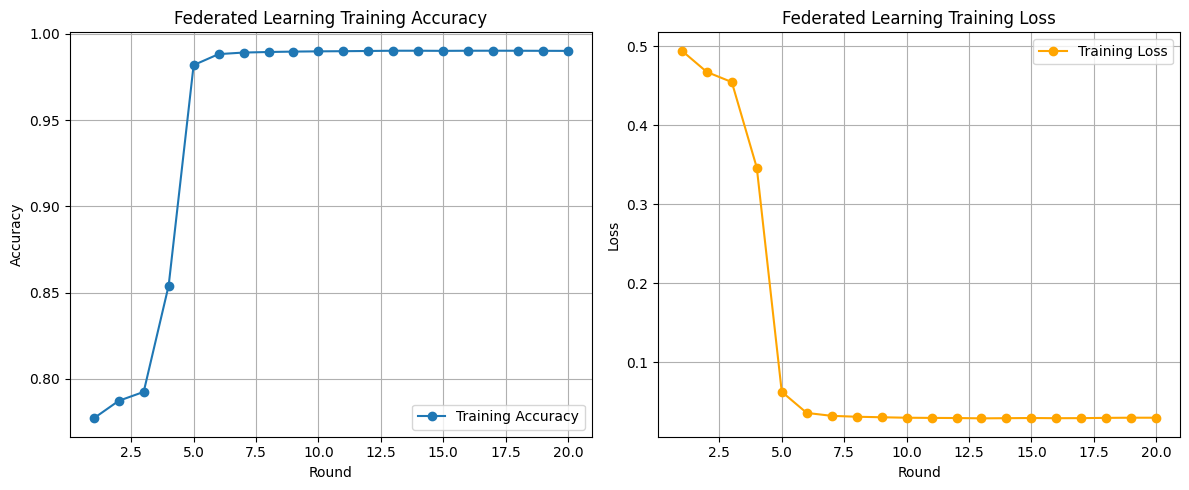

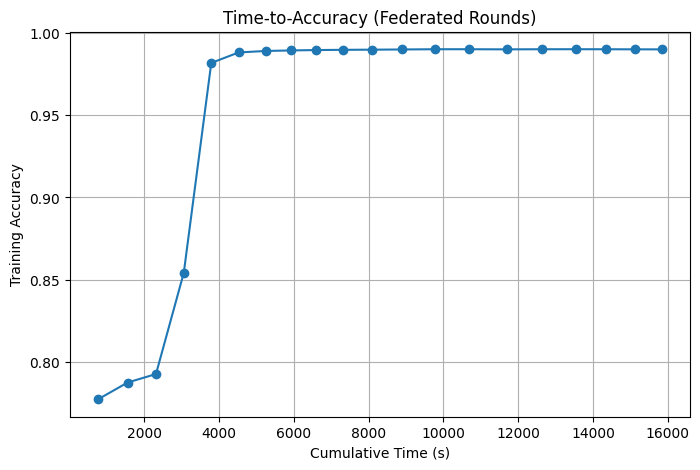


Per-Client Federated Test Metrics:
Client 1 => OrderedDict([('sparse_categorical_accuracy', 0.9925365), ('loss', 0.021490084)])
Client 2 => OrderedDict([('sparse_categorical_accuracy', 0.9925414), ('loss', 0.02160035)])
Client 3 => OrderedDict([('sparse_categorical_accuracy', 0.9927271), ('loss', 0.02113003)])
Client 4 => OrderedDict([('sparse_categorical_accuracy', 0.9924436), ('loss', 0.021898136)])
Client 5 => OrderedDict([('sparse_categorical_accuracy', 0.9923263), ('loss', 0.022123223)])
Client 6 => OrderedDict([('sparse_categorical_accuracy', 0.99250716), ('loss', 0.02170249)])
Client 7 => OrderedDict([('sparse_categorical_accuracy', 0.99311817), ('loss', 0.02089728)])

========== Classification Report (Local) ==========
                          precision    recall  f1-score   support

            ARP_Spoofing       0.68      0.42      0.52      3209
                  Benign       0.93      0.97      0.95     38546
               DDoS-ICMP       1.00      1.00      1.00    3074

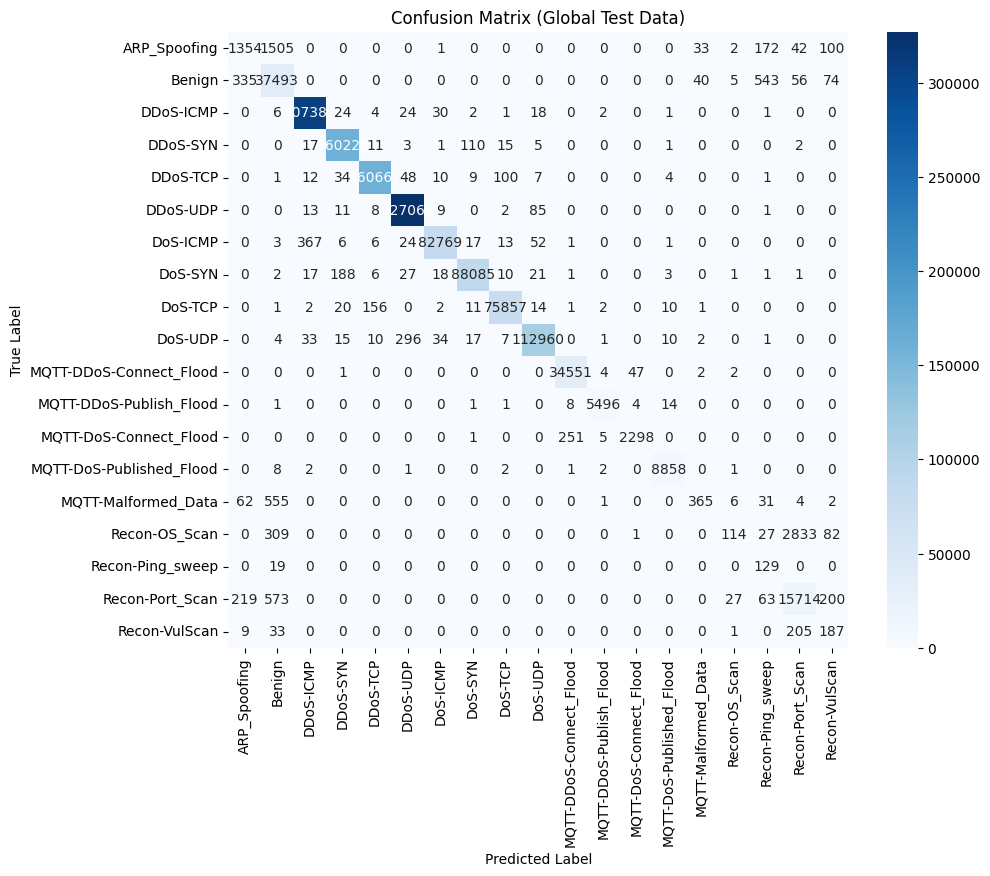

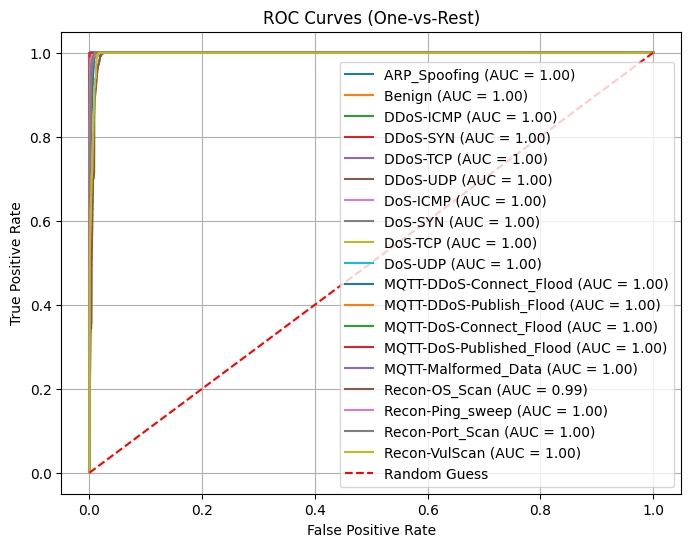


========== All Done! ==========

========== STEP 14: Additional Visualizations ==========


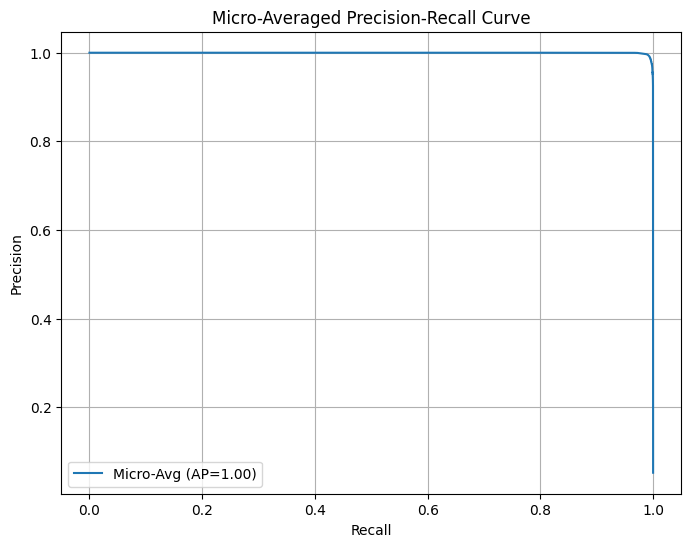

Micro-AP: 1.00, Approx Macro-AP: 0.85

========== Client-Specific Confusion Matrices ==========


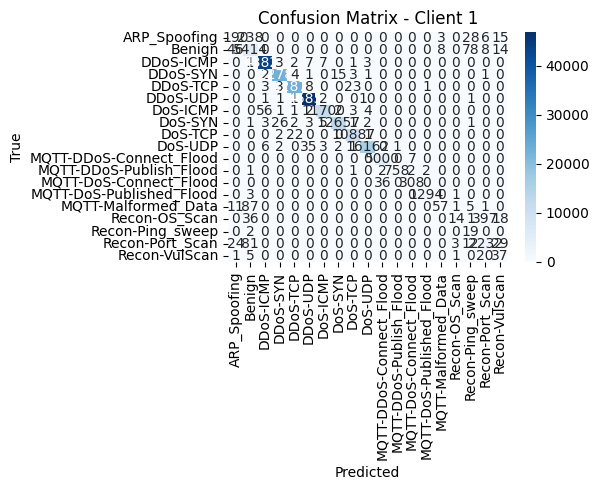

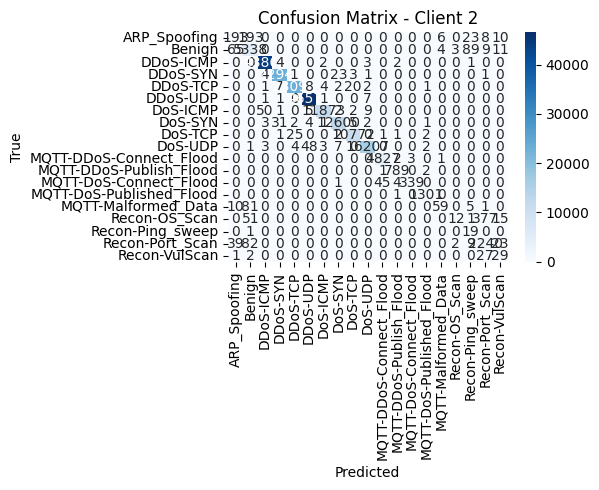

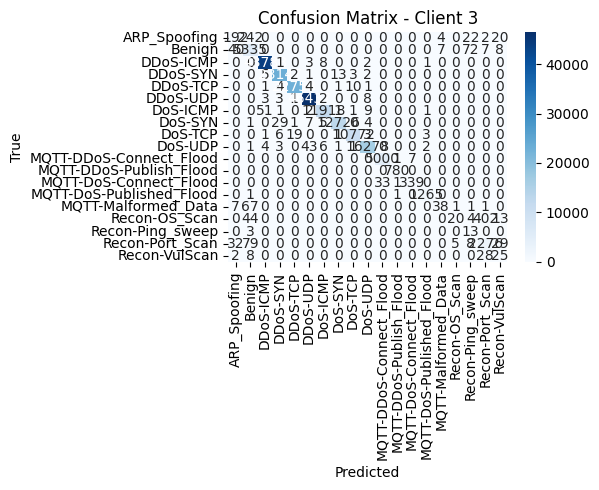

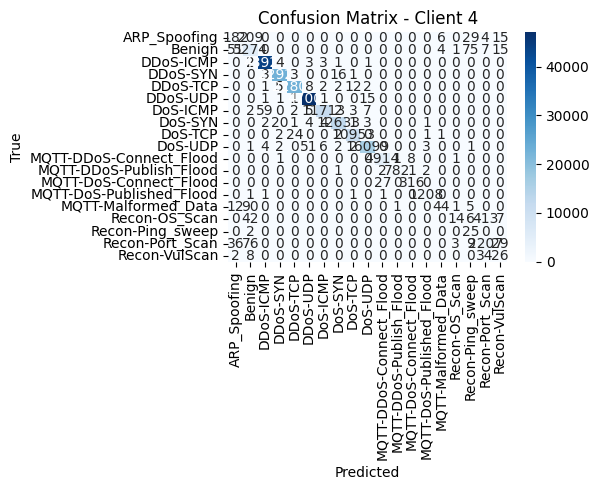

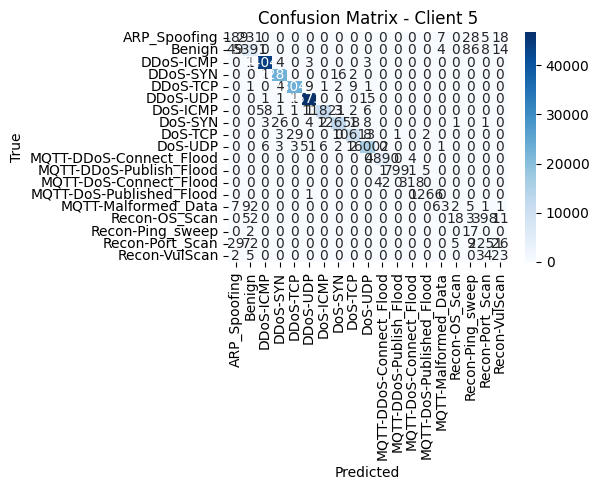

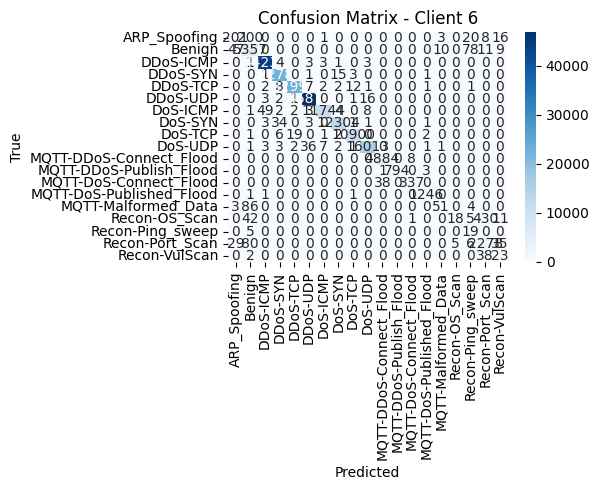

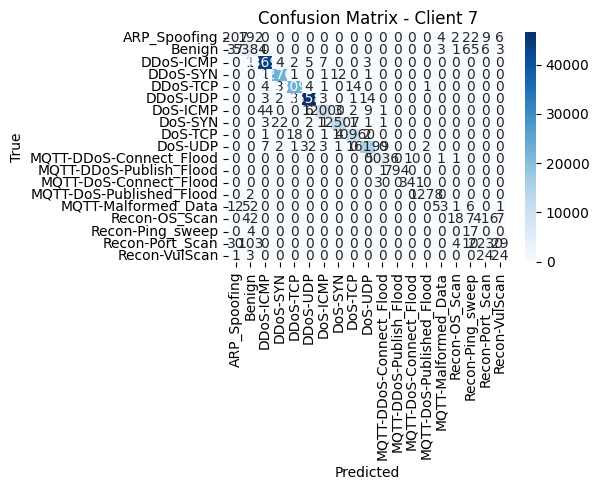


========== Additional Visualizations Complete! ==========


In [1]:
###############################################################################
# STEP 1: IMPORTS AND ENVIRONMENT SETUP
###############################################################################
import os
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output



import nest_asyncio
nest_asyncio.apply()  # For notebook/interactive environments

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time  # For time-to-accuracy tracking
from imblearn.over_sampling import ADASYN
import tensorflow as tf
import tensorflow_federated as tff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc,
    precision_score, 
    recall_score, 
    f1_score,
    precision_recall_curve,
    average_precision_score
)
from tensorflow.keras.utils import to_categorical

###############################################################################
# STEP 2: LOAD AND LABEL THE DATASET
###############################################################################
def read_and_label_csv_files(root_dir):
    dataframes = []
    for class_dir in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_dir)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                if file_name.endswith('.csv'):
                    file_path = os.path.join(class_path, file_name)
                    df = pd.read_csv(file_path)
                    df['label'] = class_dir
                    dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

root_directory = "dataset"
merged_df = read_and_label_csv_files(root_directory)
print("Step 2: Dataset shape (rows, columns) =", merged_df.shape)
# Optional: Uncomment if you want to see the first few rows
# merged_df.head()

###############################################################################
# STEP 3: ENCODE LABELS AND SELECT FEATURES
###############################################################################
label_encoder = LabelEncoder()
merged_df['label'] = label_encoder.fit_transform(merged_df['label'])
merged_df['label'] = merged_df['label'].astype(int)

X = merged_df.drop(columns=['label'])
y = merged_df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Step 3: Feature matrix shape =", X_scaled.shape)
print("Step 3: Number of classes =", len(np.unique(y)))

###############################################################################
# STEP 4: TRAIN/TEST SPLIT AND APPLY ADASYN
###############################################################################
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)
print("Step 4: After train/test split -")
print("       X_train shape =", X_train.shape, "y_train shape =", y_train.shape)
print("       X_test  shape =", X_test.shape,  "y_test  shape =", y_test.shape)

adasyn_classes = [16, 18]  # Minority classes
adasyn = ADASYN(sampling_strategy={c: 10000 for c in adasyn_classes}, random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)
print("Step 4: ADASYN Resampled class distribution:\n", pd.Series(y_resampled).value_counts())
print("Step 4: Resampled dataset shape =", X_resampled.shape)

y_onehot = to_categorical(y_resampled)

###############################################################################
# STEP 5: CREATE FEDERATED DATA
###############################################################################
def create_federated_data(X, y, num_clients):
    combined = list(zip(X, y))
    np.random.shuffle(combined)
    X_shuffled, y_shuffled = zip(*combined)
    X_shuffled = np.array(X_shuffled)
    y_shuffled = np.array(y_shuffled)

    data_per_client = len(X_shuffled) // num_clients
    federated_data = []
    for i in range(num_clients):
        start = i * data_per_client
        end = start + data_per_client if i < num_clients - 1 else len(X_shuffled)
     
        client_data = {"X": X_shuffled[start:end], "y": y_shuffled[start:end]}
        federated_data.append(client_data)
    return federated_data

num_clients = 7
federated_data = create_federated_data(X_resampled, y_resampled, num_clients)
print("Step 5: Created federated data with", num_clients, "clients.")

###############################################################################
# STEP 6: PREPROCESS FEDERATED DATA FOR TRAINING
###############################################################################
def preprocess_federated_data(client_data):
    def map_fn(x, y):
        return (
            tf.cast(tf.reshape(x, (-1, X.shape[1], 1)), tf.float32),
            y
        )
    dataset = tf.data.Dataset.from_tensor_slices((client_data["X"], client_data["y"]))
    return dataset.batch(32).map(map_fn)

federated_train_data = [preprocess_federated_data(cd) for cd in federated_data]
print("Step 6: Prepared federated data (list of batched tf.data.Datasets).")

###############################################################################
# STEP 7: DEFINE THE MODEL (SELF-ATTENTION + CNN) - 
###############################################################################
def build_self_attention_cnn(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    attention_scores = tf.keras.layers.Dense(input_shape[0], activation="softmax", name="attention")(inputs)
    attention_output = tf.keras.layers.Multiply()([inputs, attention_scores])

    x = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(attention_output)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

###############################################################################
# STEP 8: TFF MODEL FUNCTION + FEDERATED AVERAGING PROCESS
###############################################################################
def model_fn():
    keras_model = build_self_attention_cnn((X.shape[1], 1), len(np.unique(y)))
    input_spec = (
        tf.TensorSpec(shape=(None, X.shape[1], 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
    return tff.learning.from_keras_model(
        keras_model=keras_model,
        input_spec=input_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

iterative_process = tff.learning.build_federated_averaging_process(
    model_fn=model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

###############################################################################
# STEP 9: FEDERATED TRAINING (TIME-TO-ACCURACY ADDED)
###############################################################################
state = iterative_process.initialize()
NUM_ROUNDS = 20
round_metrics = []

time_per_round = []
acc_per_round = []
cumulative_time = 0.0

print("\n       Federated learning start         ")
for round_num in range(1, NUM_ROUNDS + 1):
    start_time = time.time()
    state, metrics = iterative_process.next(state, federated_train_data)
    end_time = time.time()

    round_duration = end_time - start_time
    cumulative_time += round_duration
    time_per_round.append(cumulative_time)

    round_metrics.append(metrics)
    train_acc = metrics['train']['sparse_categorical_accuracy']
    train_loss = metrics['train']['loss']
    acc_per_round.append(train_acc)

    print(f"Round {round_num}, Metrics: {metrics}, Round Duration: {round_duration:.2f}s")

###############################################################################
# STEP 10: TEST DATA PREPARATION
###############################################################################
def evaluate_federated_model(state, federated_test_data):
    evaluation = tff.learning.build_federated_evaluation(model_fn)
    return evaluation(state.model, federated_test_data)

federated_test_data = [preprocess_federated_data({"X": X_test, "y": y_test})]
evaluation_metrics = evaluate_federated_model(state, federated_test_data)
print("\nFederated Evaluation Metrics:", evaluation_metrics)

###############################################################################
# STEP 11: TRAINING ACCURACY/LOSS PLOTS + TIME-TO-ACCURACY
###############################################################################
round_accuracies = [m['train']['sparse_categorical_accuracy'] for m in round_metrics]
round_losses = [m['train']['loss'] for m in round_metrics]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_ROUNDS + 1), round_accuracies, marker='o', label='Training Accuracy')
plt.title('Federated Learning Training Accuracy')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_ROUNDS + 1), round_losses, marker='o', color='orange', label='Training Loss')
plt.title('Federated Learning Training Loss')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Time-to-Accuracy Plot
plt.figure(figsize=(8,5))
plt.plot(time_per_round, acc_per_round, marker='o')
plt.title("Time-to-Accuracy (Federated Rounds)")
plt.xlabel("Cumulative Time (s)")
plt.ylabel("Training Accuracy")
plt.grid(True)
plt.show()

###############################################################################
# STEP 12: PER-CLIENT FEDERATED EVALUATION
###############################################################################
def prepare_test_data_for_each_client(X_test, y_test, num_clients):
    combined = list(zip(X_test, y_test))
    np.random.shuffle(combined)
    X_shuffled, y_shuffled = zip(*combined)
    X_shuffled = np.array(X_shuffled)
    y_shuffled = np.array(y_shuffled)

    data_per_client = len(X_shuffled) // num_clients
    client_test_data = []
    for i in range(num_clients):
        start = i * data_per_client
        end = start + data_per_client if i < num_clients - 1 else len(X_shuffled)
        c_data = {"X": X_shuffled[start:end], "y": y_shuffled[start:end]}
        client_test_data.append(c_data)
    return client_test_data

client_test_data = prepare_test_data_for_each_client(X_test, y_test, num_clients)
federated_test_data_by_client = [preprocess_federated_data(d) for d in client_test_data]

eval_comp = tff.learning.build_federated_evaluation(model_fn)
print("\nPer-Client Federated Test Metrics:")
client_scores = []
for i, test_dataset in enumerate(federated_test_data_by_client, start=1):
    metrics_i = eval_comp(state.model, [test_dataset])
    client_scores.append(metrics_i)
    print(f"Client {i} => {metrics_i}")

###############################################################################
# STEP 13: LOCAL EVALUATION (CLASSIFICATION REPORT, CONFUSION MATRIX, ETC.)
###############################################################################
def assign_tff_weights_to_keras(keras_model, tff_state_model):
    keras_model.set_weights([np.array(w) for w in tff_state_model.trainable])

local_keras_model = build_self_attention_cnn(
    input_shape=(X.shape[1], 1),
    num_classes=len(np.unique(y))
)
assign_tff_weights_to_keras(local_keras_model, state.model)
local_keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Full test set predictions (local)
y_pred_probs = local_keras_model.predict(np.expand_dims(X_test, axis=-1))
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("\n========== Classification Report (Local) ==========")
actual_class_names = label_encoder.classes_
print(classification_report(y_test, y_pred_classes, target_names=actual_class_names))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=actual_class_names,
    yticklabels=actual_class_names
)
plt.title("Confusion Matrix (Global Test Data)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curves (One-vs-Rest)
num_classes = len(np.unique(y))
y_test_onehot = to_categorical(y_test, num_classes=num_classes)

fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_onehot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    fpr_dict[i] = fpr
    tpr_dict[i] = tpr
    roc_auc_dict[i] = roc_auc

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr_dict[i], tpr_dict[i], label=f"{actual_class_names[i]} (AUC = {roc_auc_dict[i]:.2f})")

plt.plot([0, 1], [0, 1], 'r--', label="Random Guess")
plt.title("ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print("\n========== All Done! ==========")

###############################################################################
# STEP 14: ADDITIONAL VISUALIZATIONS (MICRO/MACRO PR, CLIENT-SPECIFIC CONFUSION)
###############################################################################
print("\n========== STEP 14: Additional Visualizations ==========")

# 14.1 Micro/Macro PR Curves
precision_micro, recall_micro, _ = precision_recall_curve(y_test_onehot.ravel(), y_pred_probs.ravel())
ap_micro = average_precision_score(y_test_onehot.ravel(), y_pred_probs.ravel())

ap_macro = 0
for i in range(num_classes):
    ap_macro += average_precision_score(y_test_onehot[:, i], y_pred_probs[:, i])
ap_macro /= num_classes

plt.figure(figsize=(8, 6))
plt.plot(recall_micro, precision_micro, label=f"Micro-Avg (AP={ap_micro:.2f})")
plt.title("Micro-Averaged Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid()
plt.show()

print(f"Micro-AP: {ap_micro:.2f}, Approx Macro-AP: {ap_macro:.2f}")

# 14.2 Client-Specific Confusion Matrices
def plot_client_confusion_matrices(local_model, client_test_data, label_names):
    for i, c_data in enumerate(client_test_data, start=1):
        y_pred_c = local_model.predict(np.expand_dims(c_data["X"], axis=-1))
        y_pred_classes_c = np.argmax(y_pred_c, axis=1)
        c_mat = confusion_matrix(c_data["y"], y_pred_classes_c)

        plt.figure(figsize=(6, 5))
        sns.heatmap(
            c_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names
        )
        plt.title(f"Confusion Matrix - Client {i}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()
    

print("\n========== Client-Specific Confusion Matrices ==========")
plot_client_confusion_matrices(local_keras_model, client_test_data, actual_class_names)

print("\n========== Additional Visualizations Complete! ==========")



========== Normalized Confusion Matrix ==========


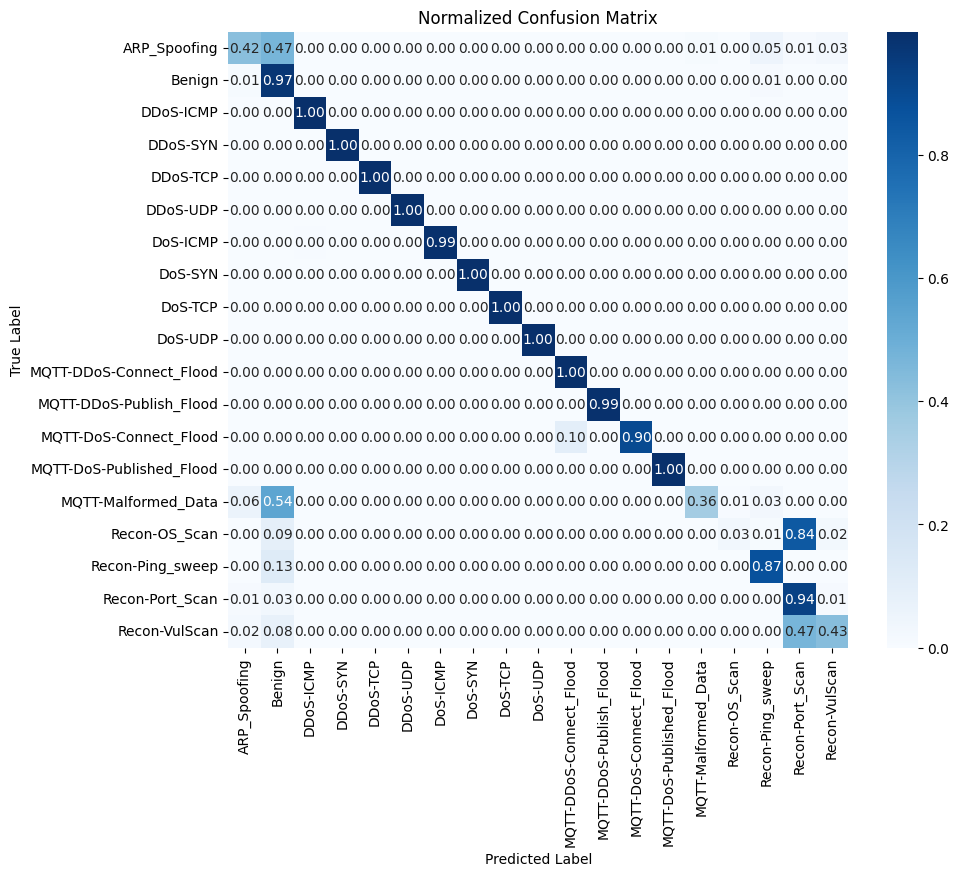


========== Class Distribution Visualization ==========


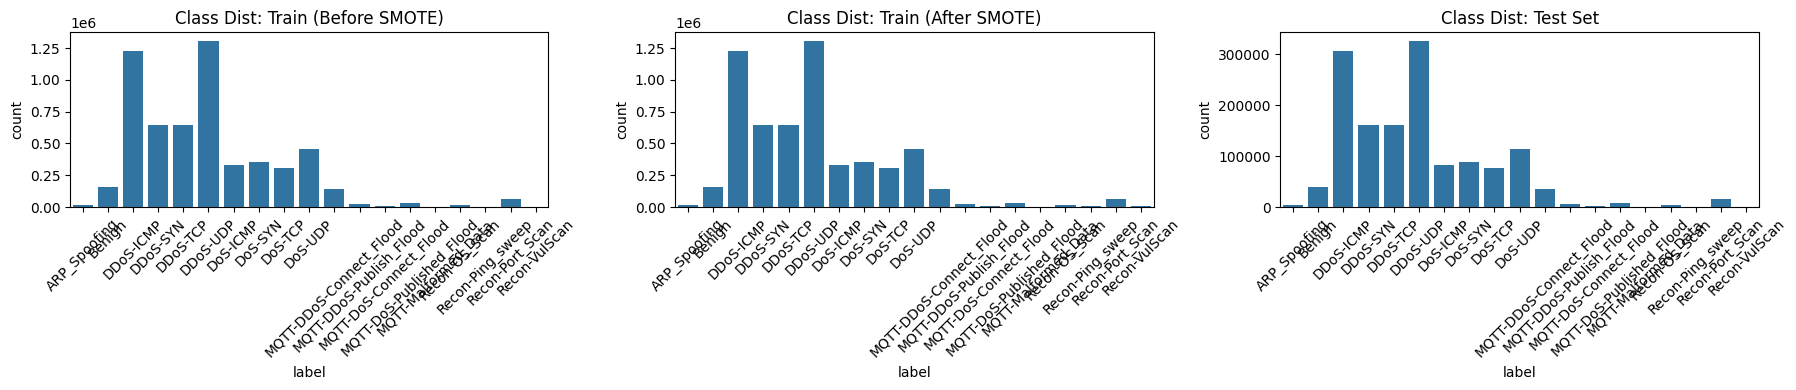


========== Per-Client Data Distribution (After SMOTE) ==========


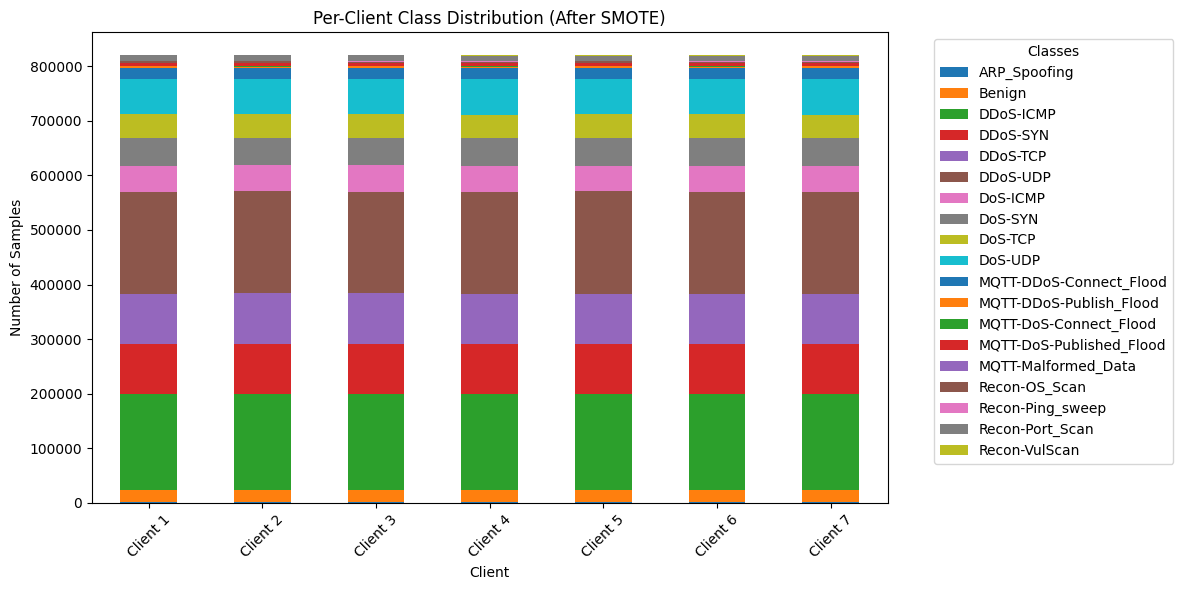


========== Per-Class Metric Bar Charts ==========


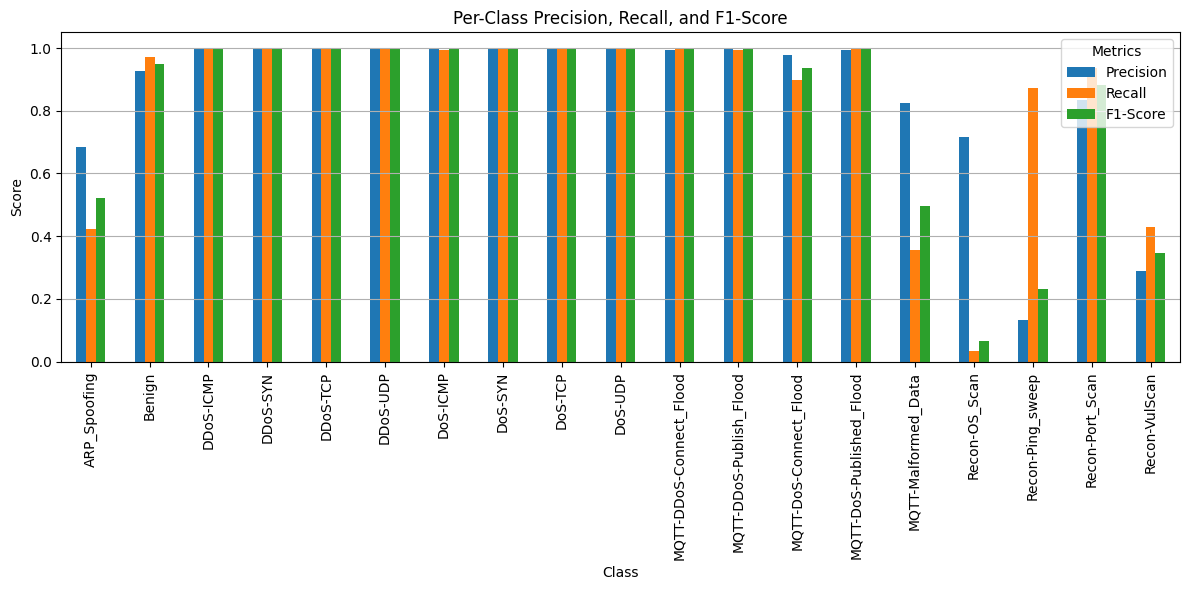


========== Additional Visualizations Complete! ==========


In [2]:
###############################################################################
# 14.2. Normalized Confusion Matrix
###############################################################################
print("\n========== Normalized Confusion Matrix ==========")
conf_mat_normalized = confusion_matrix(y_test, y_pred_classes, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_mat_normalized, 
    annot=True,
    fmt=".2f",
    cmap='Blues', 
    xticklabels=actual_class_names, 
    yticklabels=actual_class_names
)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

###############################################################################
# 14.3. Class Support Distribution (Before/After SMOTE + Test)
###############################################################################
print("\n========== Class Distribution Visualization ==========")
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

# (a) Before SMOTE (training set)
sns.countplot(x=y_train, ax=ax[0], order=np.arange(len(actual_class_names)))
ax[0].set_title("Class Dist: Train Before ")
ax[0].set_xticks(range(len(actual_class_names)))
ax[0].set_xticklabels(actual_class_names, rotation=45)

# (b) After SMOTE (training set)
sns.countplot(x=y_resampled, ax=ax[1], order=np.arange(len(actual_class_names)))
ax[1].set_title("Class Dist: Train After ")
ax[1].set_xticks(range(len(actual_class_names)))
ax[1].set_xticklabels(actual_class_names, rotation=45)

# (c) Test set
sns.countplot(x=y_test, ax=ax[2], order=np.arange(len(actual_class_names)))
ax[2].set_title("Class Dist: Test Set")
ax[2].set_xticks(range(len(actual_class_names)))
ax[2].set_xticklabels(actual_class_names, rotation=45)

plt.tight_layout()
plt.show()

###############################################################################
# 14.4. Per-Client Data Distribution (After SMOTE)
###############################################################################
print("\n========== Per-Client Data Distribution  ==========")
import collections

client_distributions = []
for i, cdata in enumerate(federated_data, start=1):
    class_counts = collections.Counter(cdata["y"])
    # Convert counts to an array matching the order of actual_class_names
    client_distribution = [class_counts.get(cls_idx, 0) for cls_idx in range(len(actual_class_names))]
    client_distributions.append(client_distribution)

client_dist_df = pd.DataFrame(client_distributions, columns=actual_class_names, index=[f"Client {i}" for i in range(1, num_clients+1)])
client_dist_df.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("Per-Client Class Distribution")
plt.xlabel("Client")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

###############################################################################
# 14.5. Per-Class Metric Bar Charts (Extracted from Classification Report)
###############################################################################
print("\n========== Per-Class Metric Bar Charts ==========")
report_dict = classification_report(y_test, y_pred_classes, target_names=actual_class_names, output_dict=True)
class_metrics = {
    "Class": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

for class_name, metrics_val in report_dict.items():
    # Skip 'accuracy', 'macro avg', 'weighted avg'
    if class_name in actual_class_names:  # class_name will be the actual label
        class_metrics["Class"].append(class_name)
        class_metrics["Precision"].append(metrics_val["precision"])
        class_metrics["Recall"].append(metrics_val["recall"])
        class_metrics["F1-Score"].append(metrics_val["f1-score"])

df_class_metrics = pd.DataFrame(class_metrics)
df_class_metrics.set_index("Class", inplace=True)
df_class_metrics.plot(kind="bar", figsize=(12, 6))
plt.title("Per-Class Precision, Recall, and F1-Score")
plt.xlabel("Class")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis="y")
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()

print("\n========== Additional Visualizations Complete! ==========")

In [3]:
###############################################################################
# 14.6. Per-Client Normalized Confusion Matrices
###############################################################################

def plot_per_client_normalized_confusion_matrices(local_model, client_test_data, class_names, num_clients):
    """
    Plots normalized confusion matrices as heatmaps for each federated client.
    
    Parameters:
    - local_model: Trained Keras model.
    - client_test_data: List of dictionaries with 'X' and 'y' for each client.
    - class_names: List or array of actual class names.
    - num_clients: Number of federated clients.
    """
    cols = 3
    rows = (num_clients + cols - 1) // cols  # Ceiling division for subplot grid
    
    plt.figure(figsize=(cols * 6, rows * 5))
    
    for i in range(num_clients):
        client_X = client_test_data[i]['X']
        client_y_true = client_test_data[i]['y']
        
        # Predict using the local model
        client_y_pred_probs = local_model.predict(np.expand_dims(client_X, axis=-1))
        client_y_pred = np.argmax(client_y_pred_probs, axis=1)
        
        # Compute normalized confusion matrix
        conf_mat_norm = confusion_matrix(client_y_true, client_y_pred, normalize='true')
        
        # Plot heatmap for the client
        plt.subplot(rows, cols, i + 1)
        sns.heatmap(
            conf_mat_norm,
            annot=False,            # Set to True to display numbers
            fmt=".2f",
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names
        )
        plt.title(f"Client {i+1} Normalized Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()


Client 1 - Precision: 0.86, Recall: 0.84, F1-Score: 0.81
Client 2 - Precision: 0.86, Recall: 0.84, F1-Score: 0.81
Client 3 - Precision: 0.86, Recall: 0.83, F1-Score: 0.81
Client 4 - Precision: 0.86, Recall: 0.83, F1-Score: 0.81
Client 5 - Precision: 0.86, Recall: 0.83, F1-Score: 0.81
Client 6 - Precision: 0.86, Recall: 0.83, F1-Score: 0.81
Client 7 - Precision: 0.87, Recall: 0.84, F1-Score: 0.82


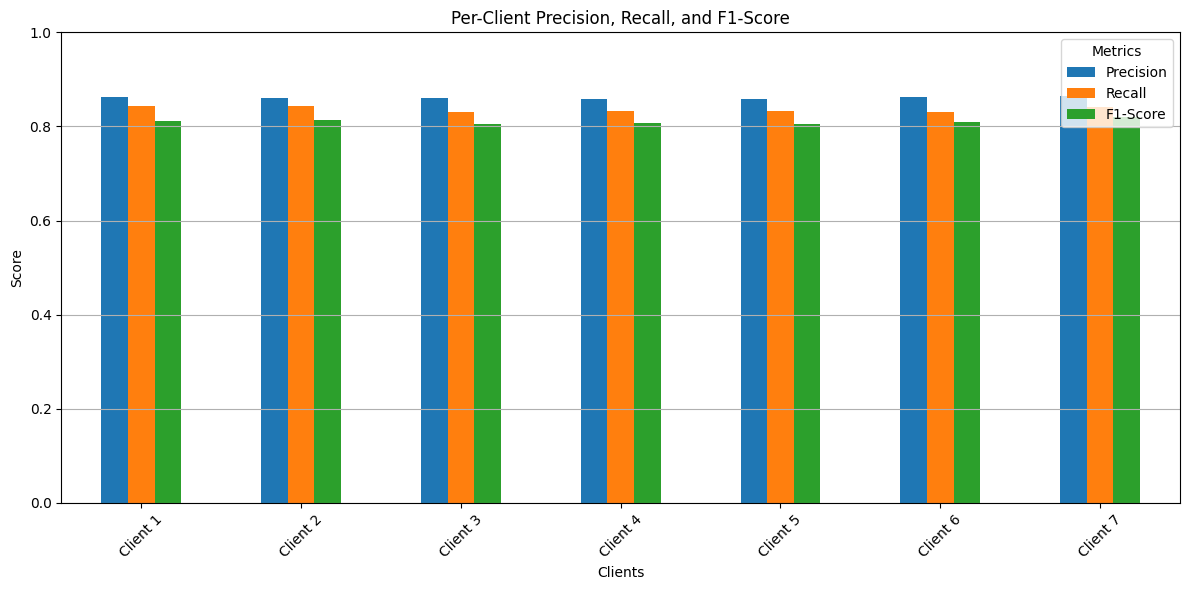

In [4]:
###############################################################################

# (CONFUSION MATRIX, CLASSIFICATION REPORT, ROC CURVES, etc.)
###############################################################################
# Import additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score

# Function to evaluate each client and compute precision, recall, F1-score
def evaluate_clients_metrics(local_model, client_test_data):
    metrics = {"Client": [], "Precision": [], "Recall": [], "F1-Score": []}

    for client_id, client_data in enumerate(client_test_data, start=1):
        # Predict using the local model
        y_pred = local_model.predict(np.expand_dims(client_data["X"], axis=-1))
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Compute metrics
        precision = precision_score(client_data["y"], y_pred_classes, average="macro")
        recall = recall_score(client_data["y"], y_pred_classes, average="macro")
        f1 = f1_score(client_data["y"], y_pred_classes, average="macro")

        # Append metrics for the client
        metrics["Client"].append(f"Client {client_id}")
        metrics["Precision"].append(precision)
        metrics["Recall"].append(recall)
        metrics["F1-Score"].append(f1)

        # Print individual metrics
        print(f"Client {client_id} - Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

    return metrics

# Function to visualize metrics for each client
def visualize_client_metrics(metrics_df):
    metrics_df.set_index("Client", inplace=True)
    metrics_df.plot(kind="bar", figsize=(12, 6))
    plt.title("Per-Client Precision, Recall, and F1-Score")
    plt.xlabel("Clients")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.grid(axis="y")
    plt.legend(title="Metrics")
    plt.tight_layout()
    plt.show()

# Helper function to assign TFF model weights to Keras model
def assign_tff_weights_to_keras(keras_model, tff_state_model):
    """
    Set local Keras model weights from TFF model state.
    """
    keras_model.set_weights([np.array(w) for w in tff_state_model.trainable])

# 13.1. Rebuild local Keras model with the same architecture:
local_keras_model = build_self_attention_cnn(
    input_shape=(X.shape[1], 1),
    num_classes=len(np.unique(y))
)

# 13.2. Assign weights from the federated model to the local Keras model
assign_tff_weights_to_keras(local_keras_model, state.model)

# 13.3. Compile the local model
local_keras_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['sparse_categorical_accuracy']
)

# 13.4. Predict locally on the entire test set (if needed for global metrics)
# Uncomment if needed
# y_pred_probs_global = local_keras_model.predict(np.expand_dims(X_test, axis=-1))
# y_pred_classes_global = np.argmax(y_pred_probs_global, axis=1)

# 13.5. Evaluate metrics for each client
client_metrics = evaluate_clients_metrics(local_keras_model, client_test_data)

# 13.6. Convert to DataFrame and visualize
client_metrics_df = pd.DataFrame(client_metrics)
visualize_client_metrics(client_metrics_df)


# 10 clients 

Step 2: Dataset shape (rows, columns) = (7160831, 46)
Step 3: Feature matrix shape = (7160831, 45)
Step 3: Number of classes = 19
Step 4: After train/test split -
       X_train shape = (5728664, 45) y_train shape = (5728664,)
       X_test  shape = (1432167, 45) y_test  shape = (1432167,)
Step 4: ADASYN Resampled class distribution:
 label
5     1308765
2     1229981
4      643572
3      641569
9      453560
7      353522
6      333033
8      304307
1      154186
10     138429
17      67185
13      35501
11      22098
15      13466
0       12838
12      10218
16      10012
18       9660
14       4104
Name: count, dtype: int64
Step 4: Resampled dataset shape = (5746006, 45)
Step 5: Created federated data with 10 clients.
Step 6: Prepared federated data (list of batched tf.data.Datasets).

       Federated learning start         
Round 1, Metrics: OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict(

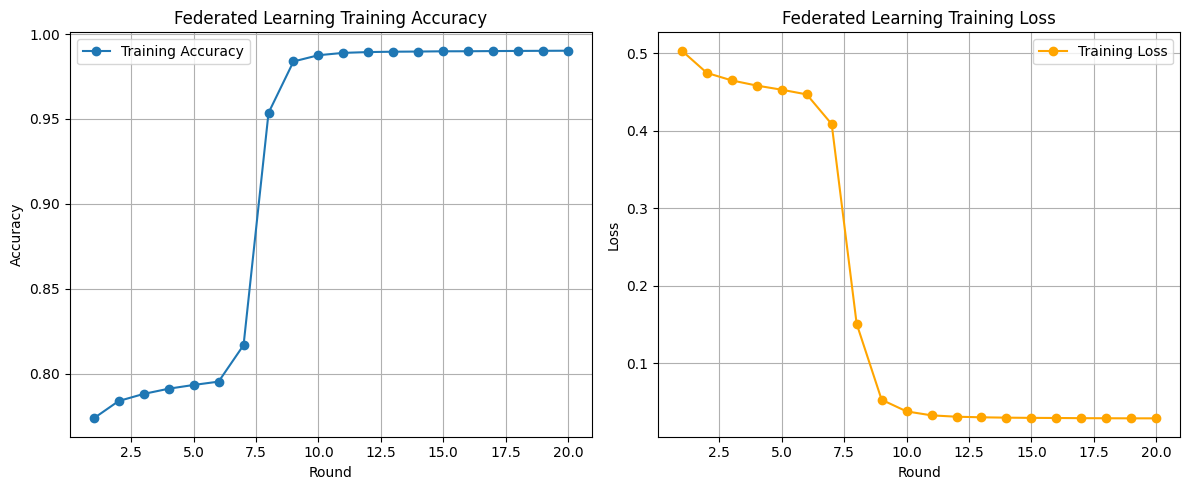

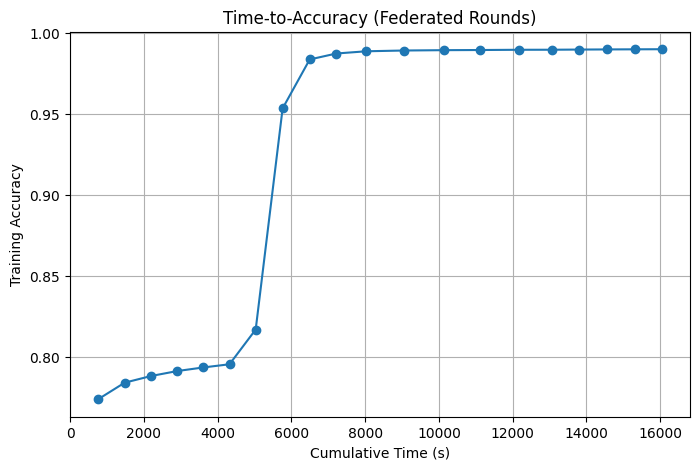


Per-Client Federated Test Metrics:
Client 1 => OrderedDict([('sparse_categorical_accuracy', 0.9922495), ('loss', 0.02159954)])
Client 2 => OrderedDict([('sparse_categorical_accuracy', 0.992445), ('loss', 0.021038087)])
Client 3 => OrderedDict([('sparse_categorical_accuracy', 0.99233323), ('loss', 0.021792358)])
Client 4 => OrderedDict([('sparse_categorical_accuracy', 0.9925497), ('loss', 0.021242637)])
Client 5 => OrderedDict([('sparse_categorical_accuracy', 0.9923961), ('loss', 0.021135544)])
Client 6 => OrderedDict([('sparse_categorical_accuracy', 0.9920749), ('loss', 0.022289332)])
Client 7 => OrderedDict([('sparse_categorical_accuracy', 0.9921168), ('loss', 0.022005891)])
Client 8 => OrderedDict([('sparse_categorical_accuracy', 0.99289185), ('loss', 0.020588277)])
Client 9 => OrderedDict([('sparse_categorical_accuracy', 0.9925288), ('loss', 0.02117202)])
Client 10 => OrderedDict([('sparse_categorical_accuracy', 0.9922778), ('loss', 0.022148546)])

========== Classification Report 

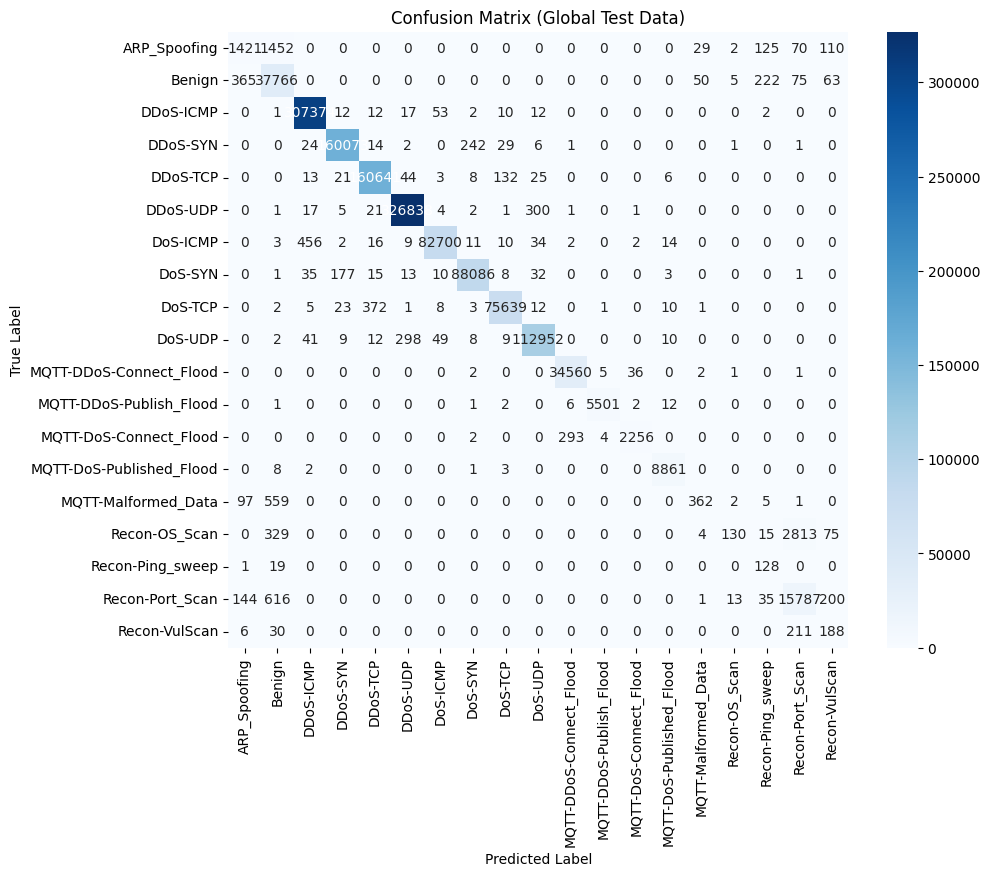

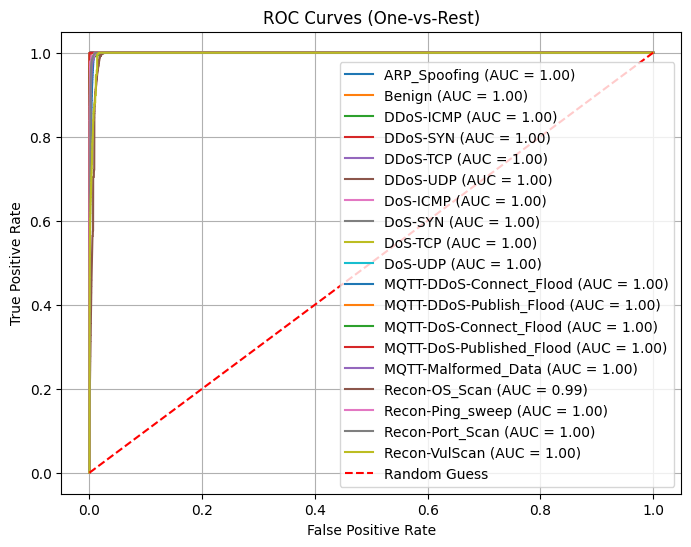


========== STEP 14: Additional Visualizations ==========


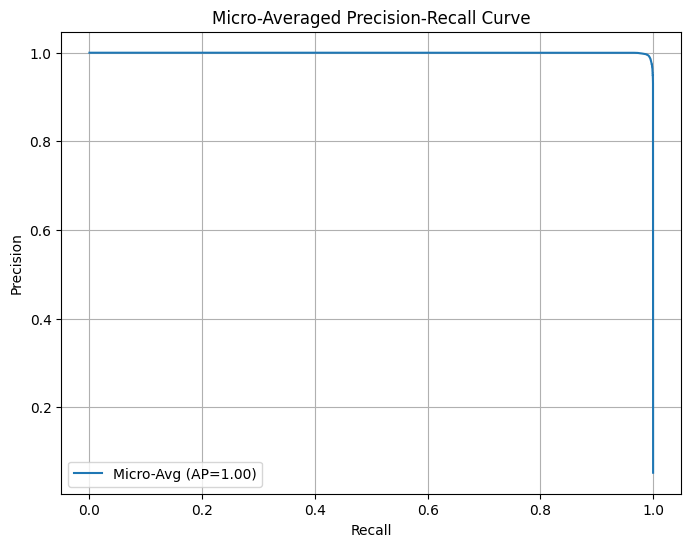

Micro-AP: 1.00, Approx Macro-AP: 0.86

========== Client-Specific Confusion Matrices ==========


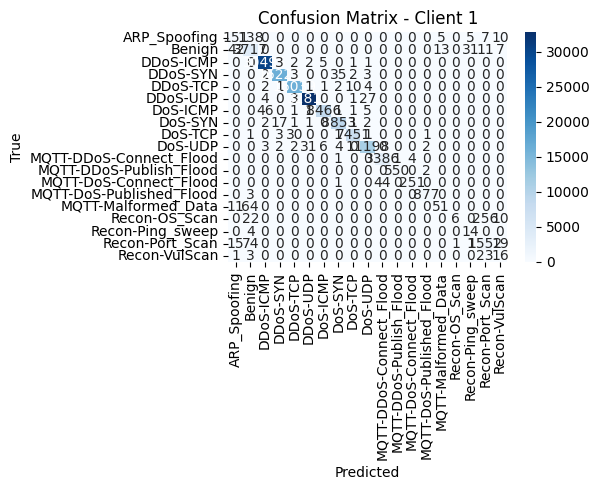

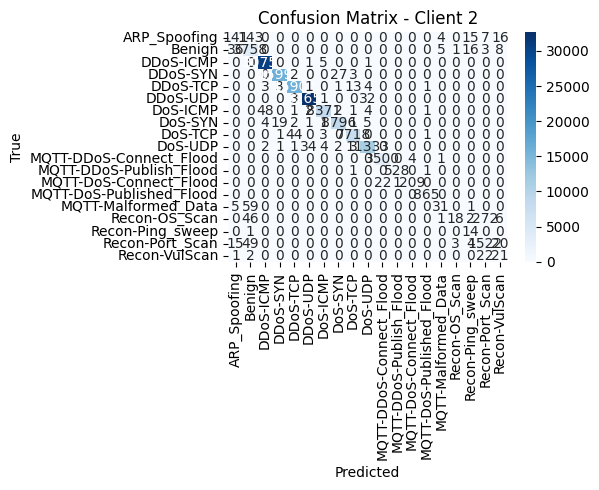

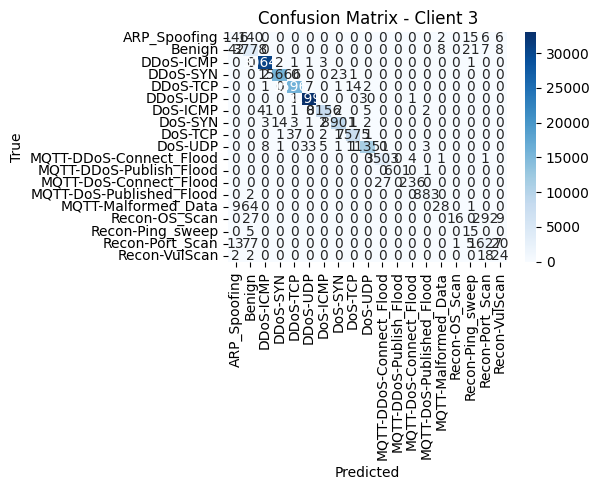

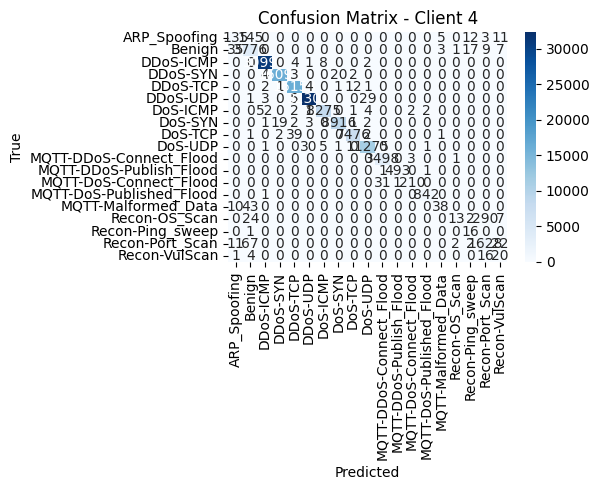

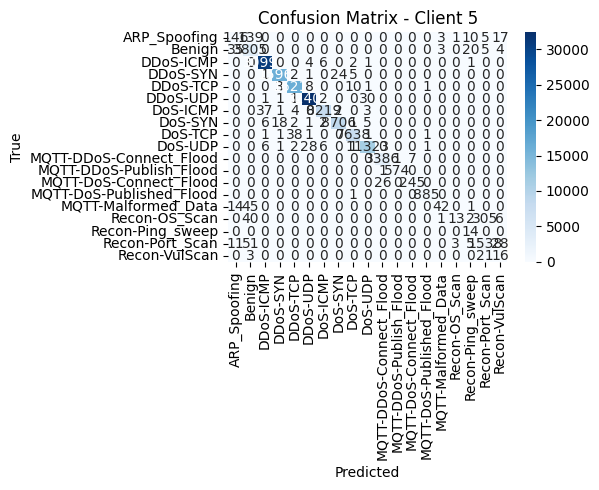

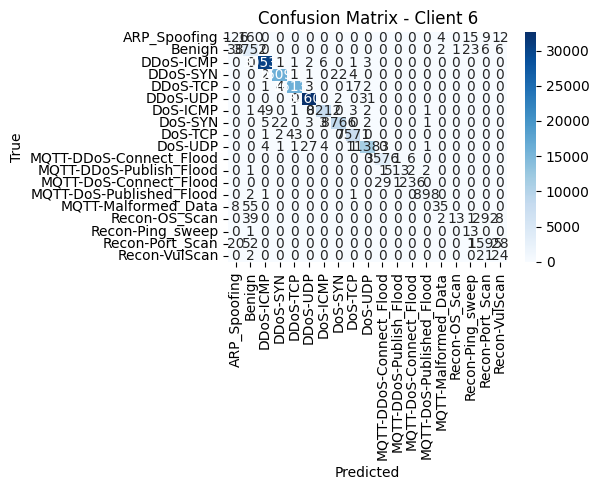

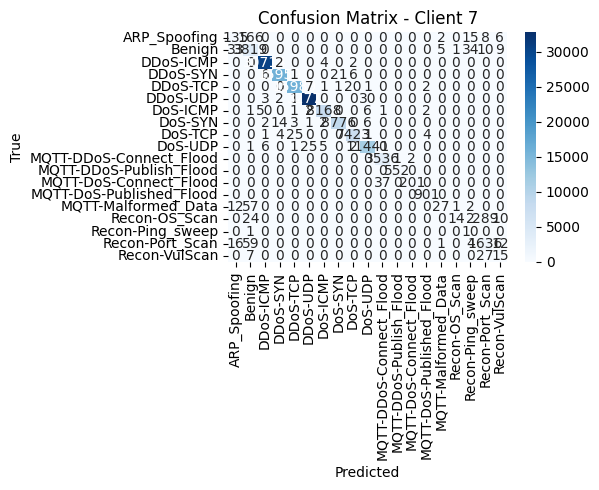

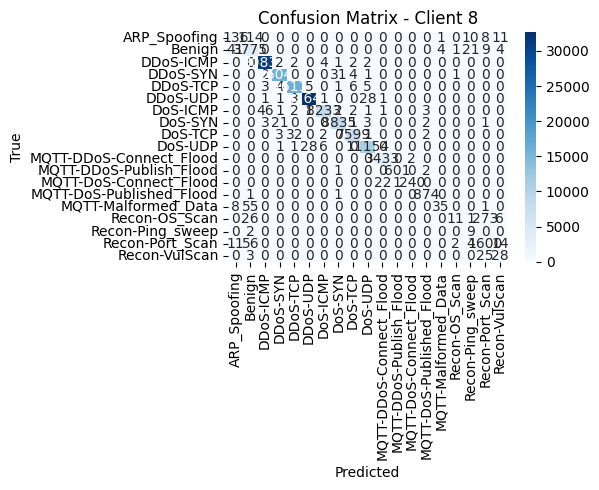

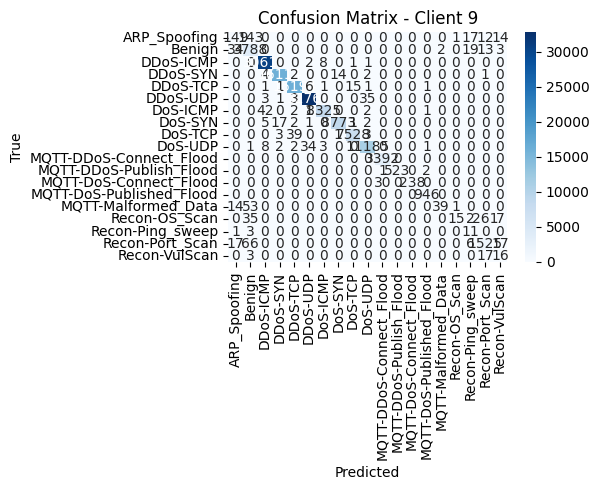

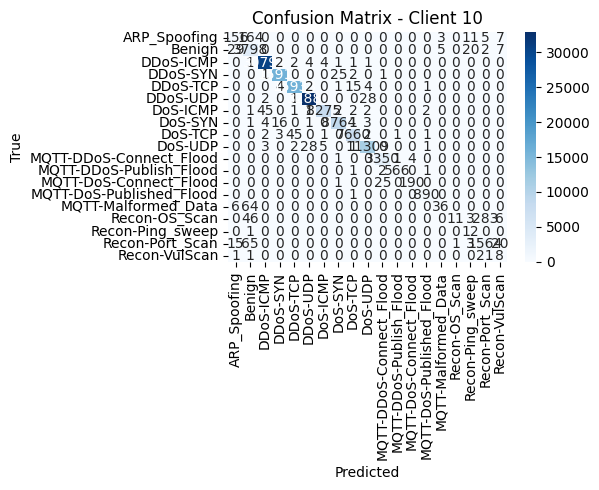

In [5]:
###############################################################################
# STEP 1: IMPORTS AND ENVIRONMENT SETUP
###############################################################################
import os
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output

from imblearn.over_sampling import ADASYN

import nest_asyncio
nest_asyncio.apply()  # For notebook/interactive environments

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time  # For time-to-accuracy tracking

import tensorflow as tf
import tensorflow_federated as tff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc,
    precision_score, 
    recall_score, 
    f1_score,
    precision_recall_curve,
    average_precision_score
)
from tensorflow.keras.utils import to_categorical

###############################################################################
# STEP 2: LOAD AND LABEL THE DATASET
###############################################################################
def read_and_label_csv_files(root_dir):
    dataframes = []
    for class_dir in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_dir)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                if file_name.endswith('.csv'):
                    file_path = os.path.join(class_path, file_name)
                    df = pd.read_csv(file_path)
                    df['label'] = class_dir
                    dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

root_directory = "dataset"
merged_df = read_and_label_csv_files(root_directory)
print("Step 2: Dataset shape (rows, columns) =", merged_df.shape)
# Optional: Uncomment if you want to see the first few rows
# merged_df.head()

###############################################################################
# STEP 3: ENCODE LABELS AND SELECT FEATURES
###############################################################################
label_encoder = LabelEncoder()
merged_df['label'] = label_encoder.fit_transform(merged_df['label'])
merged_df['label'] = merged_df['label'].astype(int)

X = merged_df.drop(columns=['label'])
y = merged_df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Step 3: Feature matrix shape =", X_scaled.shape)
print("Step 3: Number of classes =", len(np.unique(y)))

###############################################################################
# STEP 4: TRAIN/TEST SPLIT AND APPLY ADASYN
###############################################################################
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)
print("Step 4: After train/test split -")
print("       X_train shape =", X_train.shape, "y_train shape =", y_train.shape)
print("       X_test  shape =", X_test.shape,  "y_test  shape =", y_test.shape)

adasyn_classes = [16, 18]  # Minority classes
adasyn = ADASYN(sampling_strategy={c: 10000 for c in adasyn_classes}, random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)
print("Step 4: ADASYN Resampled class distribution:\n", pd.Series(y_resampled).value_counts())
print("Step 4: Resampled dataset shape =", X_resampled.shape)

y_onehot = to_categorical(y_resampled)

###############################################################################
# STEP 5: CREATE FEDERATED DATA
###############################################################################
def create_federated_data(X, y, num_clients):
    combined = list(zip(X, y))
    np.random.shuffle(combined)
    X_shuffled, y_shuffled = zip(*combined)
    X_shuffled = np.array(X_shuffled)
    y_shuffled = np.array(y_shuffled)

    data_per_client = len(X_shuffled) // num_clients
    federated_data = []
    for i in range(num_clients):
        start = i * data_per_client
        end = start + data_per_client if i < num_clients - 1 else len(X_shuffled)
        # FIXED the syntax error below:
        client_data = {"X": X_shuffled[start:end], "y": y_shuffled[start:end]}
        federated_data.append(client_data)
    return federated_data

num_clients = 10
federated_data = create_federated_data(X_resampled, y_resampled, num_clients)
print("Step 5: Created federated data with", num_clients, "clients.")

###############################################################################
# STEP 6: PREPROCESS FEDERATED DATA FOR TRAINING
###############################################################################
def preprocess_federated_data(client_data):
    def map_fn(x, y):
        return (
            tf.cast(tf.reshape(x, (-1, X.shape[1], 1)), tf.float32),
            y
        )
    dataset = tf.data.Dataset.from_tensor_slices((client_data["X"], client_data["y"]))
    return dataset.batch(32).map(map_fn)

federated_train_data = [preprocess_federated_data(cd) for cd in federated_data]
print("Step 6: Prepared federated data (list of batched tf.data.Datasets).")

###############################################################################
# STEP 7: DEFINE THE MODEL (SELF-ATTENTION + CNN) - NO CHANGE IN LAYERS
###############################################################################
def build_self_attention_cnn(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    attention_scores = tf.keras.layers.Dense(input_shape[0], activation="softmax", name="attention")(inputs)
    attention_output = tf.keras.layers.Multiply()([inputs, attention_scores])

    x = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(attention_output)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

###############################################################################
# STEP 8: TFF MODEL FUNCTION + FEDERATED AVERAGING PROCESS
###############################################################################
def model_fn():
    keras_model = build_self_attention_cnn((X.shape[1], 1), len(np.unique(y)))
    input_spec = (
        tf.TensorSpec(shape=(None, X.shape[1], 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
    return tff.learning.from_keras_model(
        keras_model=keras_model,
        input_spec=input_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

iterative_process = tff.learning.build_federated_averaging_process(
    model_fn=model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(learning_rate=0.001),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

###############################################################################
# STEP 9: FEDERATED TRAINING (TIME-TO-ACCURACY ADDED)
###############################################################################
state = iterative_process.initialize()
NUM_ROUNDS = 20
round_metrics = []

time_per_round = []
acc_per_round = []
cumulative_time = 0.0

print("\n       Federated learning start         ")
for round_num in range(1, NUM_ROUNDS + 1):
    start_time = time.time()
    state, metrics = iterative_process.next(state, federated_train_data)
    end_time = time.time()

    round_duration = end_time - start_time
    cumulative_time += round_duration
    time_per_round.append(cumulative_time)

    round_metrics.append(metrics)
    train_acc = metrics['train']['sparse_categorical_accuracy']
    train_loss = metrics['train']['loss']
    acc_per_round.append(train_acc)

    print(f"Round {round_num}, Metrics: {metrics}, Round Duration: {round_duration:.2f}s")

###############################################################################
# STEP 10: TEST DATA PREPARATION
###############################################################################
def evaluate_federated_model(state, federated_test_data):
    evaluation = tff.learning.build_federated_evaluation(model_fn)
    return evaluation(state.model, federated_test_data)

federated_test_data = [preprocess_federated_data({"X": X_test, "y": y_test})]
evaluation_metrics = evaluate_federated_model(state, federated_test_data)
print("\nFederated Evaluation Metrics:", evaluation_metrics)

###############################################################################
# STEP 11: TRAINING ACCURACY/LOSS PLOTS + TIME-TO-ACCURACY
###############################################################################
round_accuracies = [m['train']['sparse_categorical_accuracy'] for m in round_metrics]
round_losses = [m['train']['loss'] for m in round_metrics]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_ROUNDS + 1), round_accuracies, marker='o', label='Training Accuracy')
plt.title('Federated Learning Training Accuracy')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_ROUNDS + 1), round_losses, marker='o', color='orange', label='Training Loss')
plt.title('Federated Learning Training Loss')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Time-to-Accuracy Plot
plt.figure(figsize=(8,5))
plt.plot(time_per_round, acc_per_round, marker='o')
plt.title("Time-to-Accuracy (Federated Rounds)")
plt.xlabel("Cumulative Time (s)")
plt.ylabel("Training Accuracy")
plt.grid(True)
plt.show()

###############################################################################
# STEP 12: PER-CLIENT FEDERATED EVALUATION
###############################################################################
def prepare_test_data_for_each_client(X_test, y_test, num_clients):
    combined = list(zip(X_test, y_test))
    np.random.shuffle(combined)
    X_shuffled, y_shuffled = zip(*combined)
    X_shuffled = np.array(X_shuffled)
    y_shuffled = np.array(y_shuffled)

    data_per_client = len(X_shuffled) // num_clients
    client_test_data = []
    for i in range(num_clients):
        start = i * data_per_client
        end = start + data_per_client if i < num_clients - 1 else len(X_shuffled)
        c_data = {"X": X_shuffled[start:end], "y": y_shuffled[start:end]}
        client_test_data.append(c_data)
    return client_test_data

client_test_data = prepare_test_data_for_each_client(X_test, y_test, num_clients)
federated_test_data_by_client = [preprocess_federated_data(d) for d in client_test_data]

eval_comp = tff.learning.build_federated_evaluation(model_fn)
print("\nPer-Client Federated Test Metrics:")
client_scores = []
for i, test_dataset in enumerate(federated_test_data_by_client, start=1):
    metrics_i = eval_comp(state.model, [test_dataset])
    client_scores.append(metrics_i)
    print(f"Client {i} => {metrics_i}")

###############################################################################
# STEP 13: LOCAL EVALUATION (CLASSIFICATION REPORT, CONFUSION MATRIX, ETC.)
###############################################################################
def assign_tff_weights_to_keras(keras_model, tff_state_model):
    keras_model.set_weights([np.array(w) for w in tff_state_model.trainable])

local_keras_model = build_self_attention_cnn(
    input_shape=(X.shape[1], 1),
    num_classes=len(np.unique(y))
)
assign_tff_weights_to_keras(local_keras_model, state.model)
local_keras_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Full test set predictions (local)
y_pred_probs = local_keras_model.predict(np.expand_dims(X_test, axis=-1))
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("\n========== Classification Report (Local) ==========")
actual_class_names = label_encoder.classes_
print(classification_report(y_test, y_pred_classes, target_names=actual_class_names))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=actual_class_names,
    yticklabels=actual_class_names
)
plt.title("Confusion Matrix (Global Test Data)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curves (One-vs-Rest)
num_classes = len(np.unique(y))
y_test_onehot = to_categorical(y_test, num_classes=num_classes)

fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_onehot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    fpr_dict[i] = fpr
    tpr_dict[i] = tpr
    roc_auc_dict[i] = roc_auc

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr_dict[i], tpr_dict[i], label=f"{actual_class_names[i]} (AUC = {roc_auc_dict[i]:.2f})")

plt.plot([0, 1], [0, 1], 'r--', label="Random Guess")
plt.title("ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()



###############################################################################
# STEP 14: ADDITIONAL VISUALIZATIONS (MICRO/MACRO PR, CLIENT-SPECIFIC CONFUSION)
###############################################################################
print("\n========== STEP 14: Additional Visualizations ==========")

# 14.1 Micro/Macro PR Curves
precision_micro, recall_micro, _ = precision_recall_curve(y_test_onehot.ravel(), y_pred_probs.ravel())
ap_micro = average_precision_score(y_test_onehot.ravel(), y_pred_probs.ravel())

ap_macro = 0
for i in range(num_classes):
    ap_macro += average_precision_score(y_test_onehot[:, i], y_pred_probs[:, i])
ap_macro /= num_classes

plt.figure(figsize=(8, 6))
plt.plot(recall_micro, precision_micro, label=f"Micro-Avg (AP={ap_micro:.2f})")
plt.title("Micro-Averaged Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid()
plt.show()

print(f"Micro-AP: {ap_micro:.2f}, Approx Macro-AP: {ap_macro:.2f}")

# 14.2 Client-Specific Confusion Matrices
def plot_client_confusion_matrices(local_model, client_test_data, label_names):
    for i, c_data in enumerate(client_test_data, start=1):
        y_pred_c = local_model.predict(np.expand_dims(c_data["X"], axis=-1))
        y_pred_classes_c = np.argmax(y_pred_c, axis=1)
        c_mat = confusion_matrix(c_data["y"], y_pred_classes_c)

        plt.figure(figsize=(6, 5))
        sns.heatmap(
            c_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names
        )
        plt.title(f"Confusion Matrix - Client {i}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()
    

print("\n========== Client-Specific Confusion Matrices ==========")
plot_client_confusion_matrices(local_keras_model, client_test_data, actual_class_names)





========== Normalized Confusion Matrix ==========


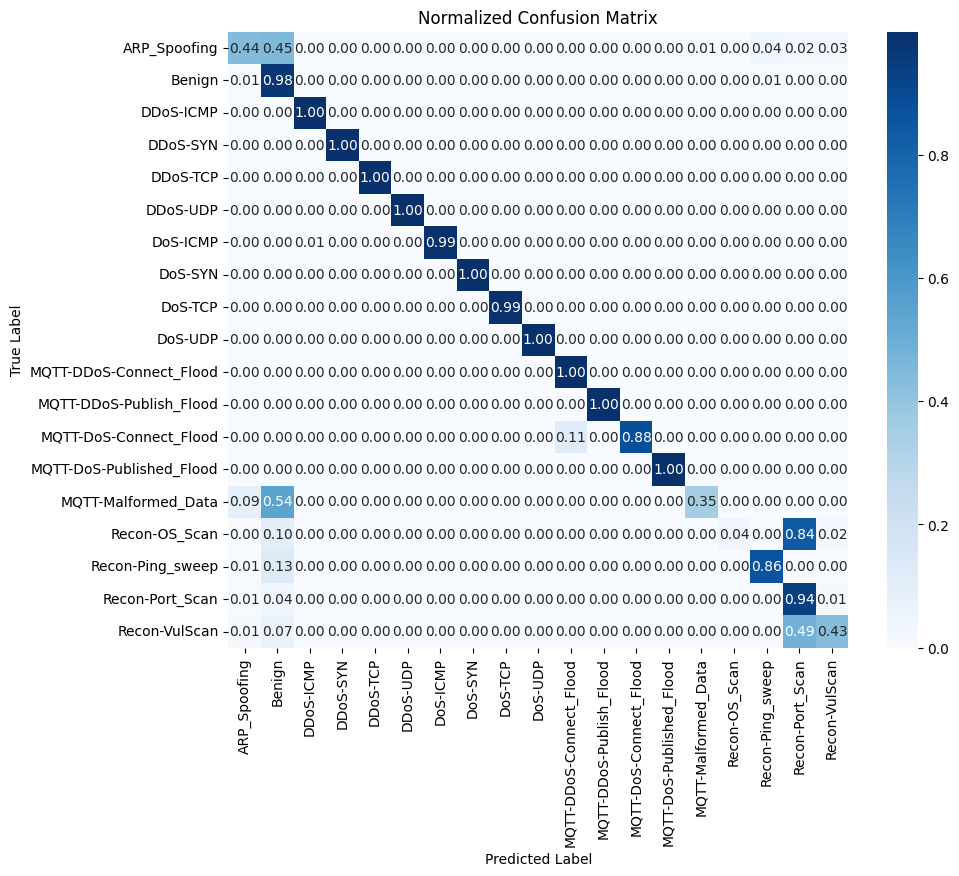


========== Class Distribution Visualization ==========


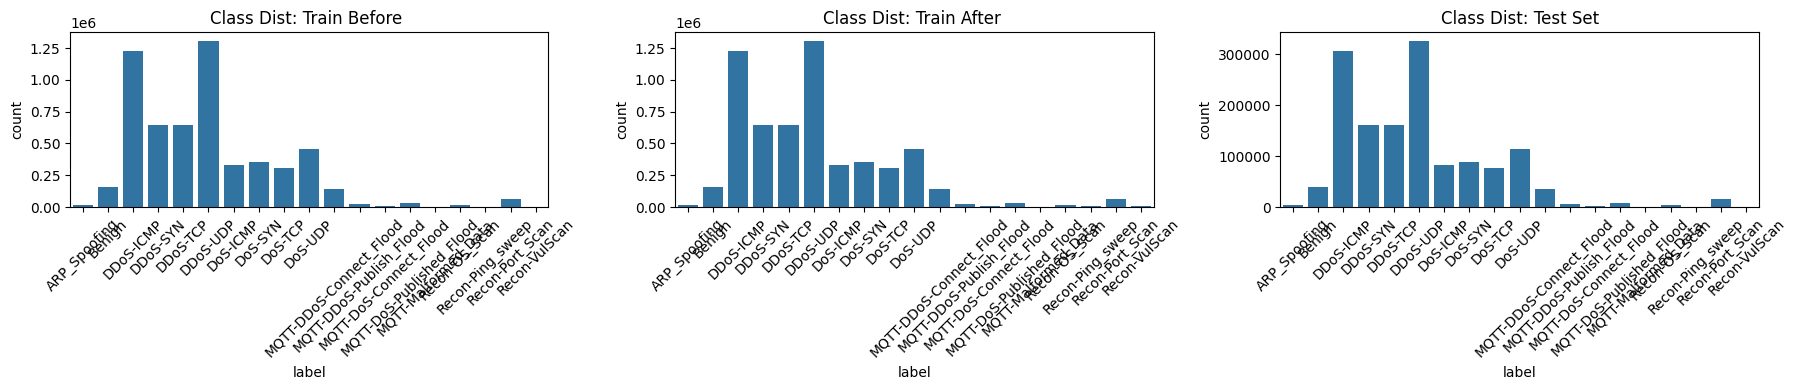


========== Per-Client Data Distribution After  ==========


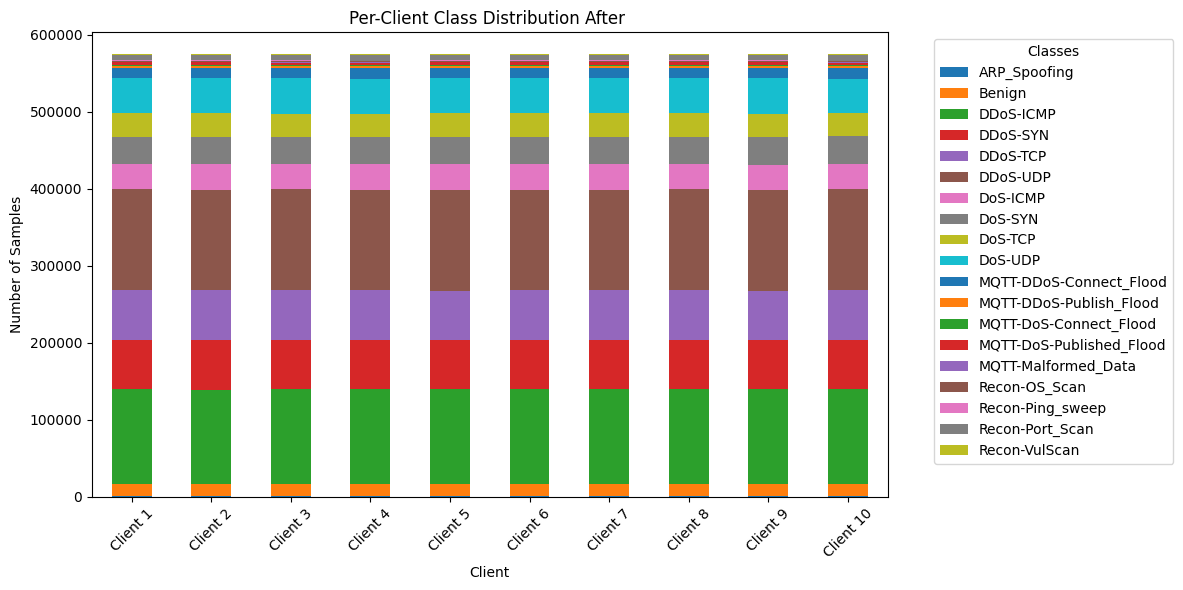


========== Per-Class Metric Bar Charts ==========


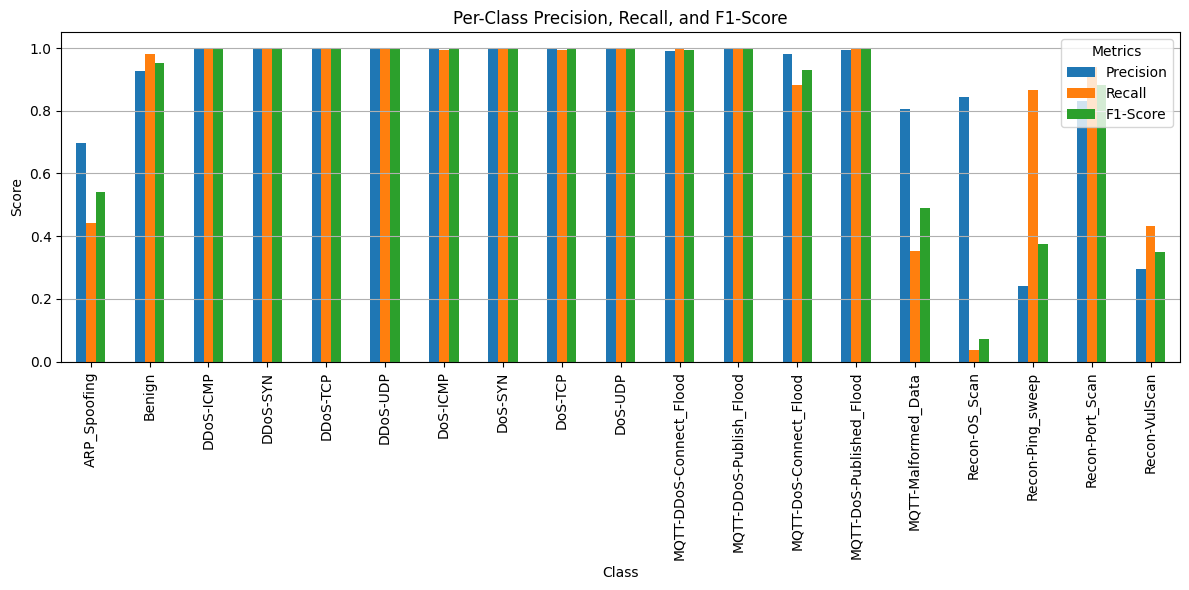


========== Additional Visualizations Complete! ==========


In [6]:
###############################################################################
# 14.2. Normalized Confusion Matrix
###############################################################################
print("\n========== Normalized Confusion Matrix ==========")
conf_mat_normalized = confusion_matrix(y_test, y_pred_classes, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_mat_normalized, 
    annot=True,
    fmt=".2f",
    cmap='Blues', 
    xticklabels=actual_class_names, 
    yticklabels=actual_class_names
)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

###############################################################################
# 14.3. Class Support Distribution (Before/After  )
###############################################################################
print("\n========== Class Distribution Visualization ==========")
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

# (a) Before SMOTE (training set)
sns.countplot(x=y_train, ax=ax[0], order=np.arange(len(actual_class_names)))
ax[0].set_title("Class Dist: Train Before ")
ax[0].set_xticks(range(len(actual_class_names)))
ax[0].set_xticklabels(actual_class_names, rotation=45)

# (b) After SMOTE (training set)
sns.countplot(x=y_resampled, ax=ax[1], order=np.arange(len(actual_class_names)))
ax[1].set_title("Class Dist: Train After ")
ax[1].set_xticks(range(len(actual_class_names)))
ax[1].set_xticklabels(actual_class_names, rotation=45)

# (c) Test set
sns.countplot(x=y_test, ax=ax[2], order=np.arange(len(actual_class_names)))
ax[2].set_title("Class Dist: Test Set")
ax[2].set_xticks(range(len(actual_class_names)))
ax[2].set_xticklabels(actual_class_names, rotation=45)

plt.tight_layout()
plt.show()

###############################################################################
# 14.4. Per-Client Data Distribution (After SMOTE)
###############################################################################
print("\n========== Per-Client Data Distribution After  ==========")
import collections

client_distributions = []
for i, cdata in enumerate(federated_data, start=1):
    class_counts = collections.Counter(cdata["y"])
    # Convert counts to an array matching the order of actual_class_names
    client_distribution = [class_counts.get(cls_idx, 0) for cls_idx in range(len(actual_class_names))]
    client_distributions.append(client_distribution)

client_dist_df = pd.DataFrame(client_distributions, columns=actual_class_names, index=[f"Client {i}" for i in range(1, num_clients+1)])
client_dist_df.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("Per-Client Class Distribution After ")
plt.xlabel("Client")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

###############################################################################
# 14.5. Per-Class Metric Bar Charts (Extracted from Classification Report)
###############################################################################
print("\n========== Per-Class Metric Bar Charts ==========")
report_dict = classification_report(y_test, y_pred_classes, target_names=actual_class_names, output_dict=True)
class_metrics = {
    "Class": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

for class_name, metrics_val in report_dict.items():
    # Skip 'accuracy', 'macro avg', 'weighted avg'
    if class_name in actual_class_names:  # class_name will be the actual label
        class_metrics["Class"].append(class_name)
        class_metrics["Precision"].append(metrics_val["precision"])
        class_metrics["Recall"].append(metrics_val["recall"])
        class_metrics["F1-Score"].append(metrics_val["f1-score"])

df_class_metrics = pd.DataFrame(class_metrics)
df_class_metrics.set_index("Class", inplace=True)
df_class_metrics.plot(kind="bar", figsize=(12, 6))
plt.title("Per-Class Precision, Recall, and F1-Score")
plt.xlabel("Class")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis="y")
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()

print("\n========== Additional Visualizations Complete! ==========")

In [7]:
###############################################################################
# 14.6. Per-Client Normalized Confusion Matrices
###############################################################################

def plot_per_client_normalized_confusion_matrices(local_model, client_test_data, class_names, num_clients):
    """
    Plots normalized confusion matrices as heatmaps for each federated client.
    
    Parameters:
    - local_model: Trained Keras model.
    - client_test_data: List of dictionaries with 'X' and 'y' for each client.
    - class_names: List or array of actual class names.
    - num_clients: Number of federated clients.
    """
    cols = 3
    rows = (num_clients + cols - 1) // cols  
    
    plt.figure(figsize=(cols * 6, rows * 5))
    
    for i in range(num_clients):
        client_X = client_test_data[i]['X']
        client_y_true = client_test_data[i]['y']
        
        # Predict using the local model
        client_y_pred_probs = local_model.predict(np.expand_dims(client_X, axis=-1))
        client_y_pred = np.argmax(client_y_pred_probs, axis=1)
        
        # Compute normalized confusion matrix
        conf_mat_norm = confusion_matrix(client_y_true, client_y_pred, normalize='true')
        
        # Plot heatmap for the client
        plt.subplot(rows, cols, i + 1)
        sns.heatmap(
            conf_mat_norm,
            annot=False,            # Set to True to display numbers
            fmt=".2f",
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names
        )
        plt.title(f"Client {i+1} Normalized Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()


Client 1 - Precision: 0.87, Recall: 0.83, F1-Score: 0.82
Client 2 - Precision: 0.87, Recall: 0.84, F1-Score: 0.82
Client 3 - Precision: 0.88, Recall: 0.83, F1-Score: 0.82
Client 4 - Precision: 0.87, Recall: 0.85, F1-Score: 0.83
Client 5 - Precision: 0.87, Recall: 0.85, F1-Score: 0.82
Client 6 - Precision: 0.88, Recall: 0.84, F1-Score: 0.82
Client 7 - Precision: 0.87, Recall: 0.83, F1-Score: 0.80
Client 8 - Precision: 0.88, Recall: 0.84, F1-Score: 0.83
Client 9 - Precision: 0.88, Recall: 0.83, F1-Score: 0.82
Client 10 - Precision: 0.87, Recall: 0.83, F1-Score: 0.81


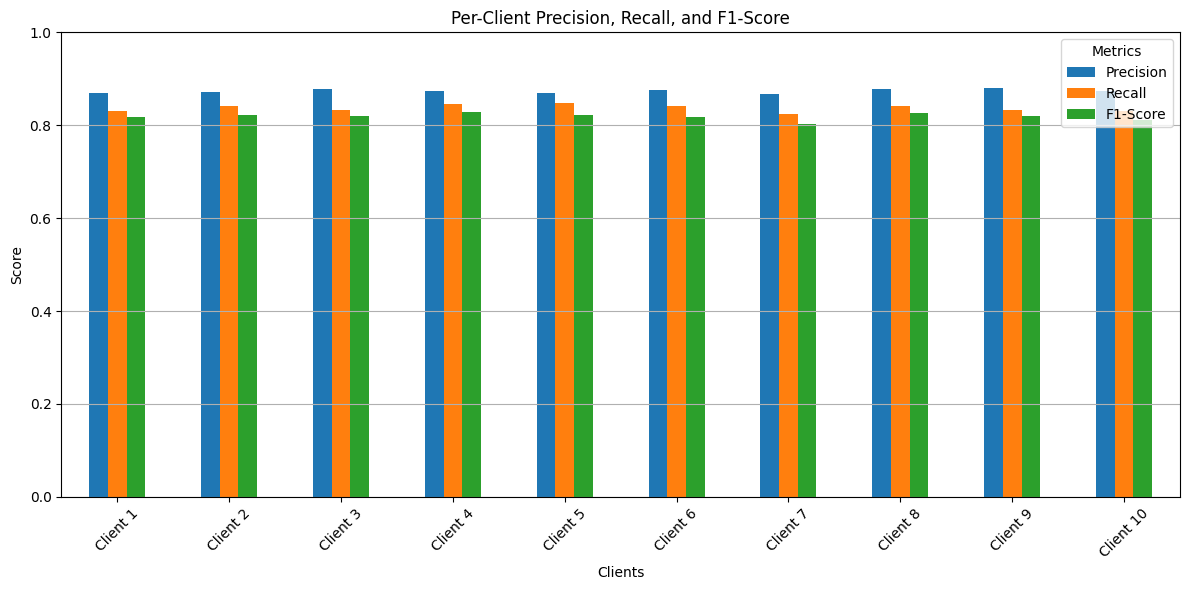

In [8]:
###############################################################################

# (CONFUSION MATRIX, CLASSIFICATION REPORT, ROC CURVES, etc.)
###############################################################################
# Import additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score

# Function to evaluate each client and compute precision, recall, F1-score
def evaluate_clients_metrics(local_model, client_test_data):
    metrics = {"Client": [], "Precision": [], "Recall": [], "F1-Score": []}

    for client_id, client_data in enumerate(client_test_data, start=1):
        # Predict using the local model
        y_pred = local_model.predict(np.expand_dims(client_data["X"], axis=-1))
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Compute metrics
        precision = precision_score(client_data["y"], y_pred_classes, average="macro")
        recall = recall_score(client_data["y"], y_pred_classes, average="macro")
        f1 = f1_score(client_data["y"], y_pred_classes, average="macro")

        # Append metrics for the client
        metrics["Client"].append(f"Client {client_id}")
        metrics["Precision"].append(precision)
        metrics["Recall"].append(recall)
        metrics["F1-Score"].append(f1)

        # Print individual metrics
        print(f"Client {client_id} - Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

    return metrics

# Function to visualize metrics for each client
def visualize_client_metrics(metrics_df):
    metrics_df.set_index("Client", inplace=True)
    metrics_df.plot(kind="bar", figsize=(12, 6))
    plt.title("Per-Client Precision, Recall, and F1-Score")
    plt.xlabel("Clients")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.grid(axis="y")
    plt.legend(title="Metrics")
    plt.tight_layout()
    plt.show()

# Helper function to assign TFF model weights to Keras model
def assign_tff_weights_to_keras(keras_model, tff_state_model):
    """
    Set local Keras model weights from TFF model state.
    """
    keras_model.set_weights([np.array(w) for w in tff_state_model.trainable])

# 13.1. Rebuild local Keras model with the same architecture:
local_keras_model = build_self_attention_cnn(
    input_shape=(X.shape[1], 1),
    num_classes=len(np.unique(y))
)

# 13.2. Assign weights from the federated model to the local Keras model
assign_tff_weights_to_keras(local_keras_model, state.model)

# 13.3. Compile the local model
local_keras_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['sparse_categorical_accuracy']
)

# 13.4. Predict locally on the entire test set (if needed for global metrics)
# Uncomment if needed
# y_pred_probs_global = local_keras_model.predict(np.expand_dims(X_test, axis=-1))
# y_pred_classes_global = np.argmax(y_pred_probs_global, axis=1)

# 13.5. Evaluate metrics for each client
client_metrics = evaluate_clients_metrics(local_keras_model, client_test_data)

# 13.6. Convert to DataFrame and visualize
client_metrics_df = pd.DataFrame(client_metrics)
visualize_client_metrics(client_metrics_df)
